## Loading the environments

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## Importing the packages

In [2]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph , START , END , MessageGraph 
from langchain_core.messages import HumanMessage , AIMessage , SystemMessage
from typing import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState

import datetime
from typing import Annotated, Sequence, List, Literal 
from pydantic import BaseModel, Field 
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults 
from langgraph.types import Command 
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent 
from IPython.display import Image, display 
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [18]:
tavily_search = TavilySearchResults()

python_repl = PythonREPLTool()

from langchain_core.tools import tool
@tool
def python_repl_tool(code:str):
    """Executes the provided Python code in a REPL environment. 
    To display the result of an expression or variable, use the print() function, 
    as only printed output will be shown to the user."""

    import traceback

    try:
        result = python_repl.run(code)
        success = True
    except Exception as e:
        tb = traceback.format_exc()
        return (
            f"Failed to execute the provided code.\n"
            f"Error: {e}\n"
            f"Traceback:\n{tb}"
        )
    
    output = (
        f"✅ Code executed successfully:\n"
        f"```python\n{code.strip()}\n```\n"
        f"**Output:**\n{result.strip() if result else '(No output)'}"
    )
    output += "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    return output

In [19]:
python_repl.invoke("x = 5; print(x)")

'5\n'

In [20]:
from prompts import supervisor_prompt , researcher_prompt , coder_prompt , validator_prompt , enhancer_prompt , refine_prompt

## creating supervisor node

In [21]:
class Supervisor(BaseModel):
    next: Literal["enhancer", "researcher", "coder"] = Field(
        description="Determines which specialist to activate next in the workflow sequence: "
                    "'enhancer' when user input requires clarification, expansion, or refinement, "
                    "'researcher' when additional facts, context, or data collection is necessary, "
                    "'coder' when implementation, computation, or technical problem-solving is required."
    )
    reason: str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )


In [22]:
def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:
    
    supervisor_node_prompt = supervisor_prompt
    
    messages = [
        {"role": "system", "content": supervisor_node_prompt},  
    ] + state["messages"] 

    response = model.with_structured_output(Supervisor).invoke(messages)

    goto_next_node = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor → {goto_next_node.upper()} ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto_next_node
    )

## creating enhnacer node

In [23]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:

    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
    enhancer_node_prompt = enhancer_prompt
    messages = [
        {"role": "system", "content": enhancer_node_prompt},  
    ] + state["messages"]  

    enhanced_query = model.invoke(messages)

    print(f"--- Workflow Transition: Prompt Enhancer → Supervisor ---")

    return Command(
        update={
            "messages": [  
                HumanMessage(
                    content=enhanced_query.content, 
                    name="enhancer"  
                )
            ]
        },
        goto="supervisor"
    )

## Creating researcher Node

In [24]:
def research_node(state: MessagesState) -> Command[Literal["validator"]]:

    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """

    researcher_node_prompt = researcher_prompt
    
    research_agent = create_react_agent(
        model,  
        tools=[tavily_search],  
        prompt = researcher_node_prompt
    )

    result = research_agent.invoke(state)

    print(f"--- Workflow Transition: Researcher → Validator ---")

    return Command(
        update={
            "messages": [ 
                HumanMessage(
                    content=result["messages"][-1].content,  
                    name="researcher"  
                )
            ]
        },
        goto="validator"
    )

## Creating coder node

In [25]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:

    code_node_prompt = coder_prompt

    code_agent = create_react_agent(
        model,
        tools=[python_repl_tool],
        prompt=code_node_prompt
    )

    result = code_agent.invoke(state)

    print(f"--- Workflow Transition: Coder → Validator ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator"
    )

## Creating validator node

In [26]:

class Validator(BaseModel):

    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:

    validator_node_prompt = validator_prompt

    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    messages = [
        {"role": "system", "content": validator_node_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = model.with_structured_output(Validator).invoke(messages)

    goto_next_node = response.next
    reason = response.reason

    if goto_next_node == "FINISH" or goto_next_node == END:
        goto_next_node = END  

        refine_ans_prompt = refine_prompt

        final_msg = [
        {"role": "system", "content": refine_ans_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer}]

        final_response = model.invoke(final_msg).content

        print(" --- Transitioning to END ---")  

        return Command(
            update={
                "messages": [
                    HumanMessage(content=final_response, name="validator")
                ]
            },
            goto=goto_next_node
        )
        
    else:
        print(f"--- Workflow Transition: Validator → Supervisor ---")
 

        return Command(
            update={
                "messages": [
                    HumanMessage(content=reason, name="validator")
                ]
            },
            goto=goto_next_node
        )

## defining the state

In [27]:
graph = StateGraph(MessagesState)
graph.add_node("supervisor", supervisor_node) 
graph.add_node("enhancer", enhancer_node)  
graph.add_node("researcher", research_node) 
graph.add_node("coder", code_node) 
graph.add_node("validator", validator_node)  

graph.add_edge(START, "supervisor")  
app = graph.compile()

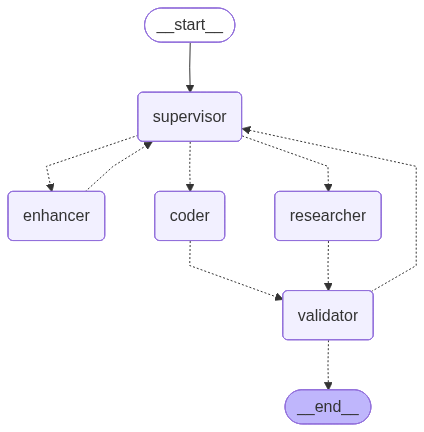

In [28]:

display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

In [29]:
import pprint

inputs = {
    "messages": [
        ("user", "Weather in Chennai"),
    ]
}

for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → RESEARCHER ---
"Output from node 'supervisor':"
HumanMessage(content="The user's request is clear and specific, seeking current weather information for Chennai, which requires up-to-date data gathering best handled by the researcher.", additional_kwargs={}, response_metadata={}, name='supervisor', id='f4e1631b-29b7-4d15-966c-d3beb454bccb')

--- Workflow Transition: Researcher → Validator ---
"Output from node 'researcher':"
HumanMessage(content='The current weather in Chennai is as follows:\n- Condition: Fog\n- Temperature: Feels like 87 °F (about 31 °C)\n- Forecast: High around 88 °F (31 °C), Low around 79 °F (26 °C)\n- Wind: 5 mph from the West\n- Humidity: 89%\n- Visibility: 3 miles\n- Dew Point: 77 °F (25 °C)\n- Pressure: 29.83 "Hg\n\nThere is a possibility of moderate rain or thunderstorms today with partly cloudy skies.\n\nSource: [Time and Date - Chennai Weather](https://www.timeanddate.com/weather/india/chennai) (updated Oct 10, 2025)', add

In [30]:
result = app.invoke(inputs)
pprint.pprint(result["messages"][-1].content)

--- Workflow Transition: Supervisor → RESEARCHER ---
--- Workflow Transition: Researcher → Validator ---
 --- Transitioning to END ---
('Currently in Chennai, the weather is partly to mostly cloudy with a chance '
 'of moderate rain or thunderstorms, especially in the evening. Temperatures '
 'today range from around 26°C to 35°C, with humidity levels near 70-75%. '
 'Winds are shifting from north to south at 5 to 15 mph. Thunderstorms '
 'accompanied by lightning are possible.\n'
 '\n'
 'For the most accurate and up-to-date weather information, you can check:\n'
 '- AccuWeather: '
 'https://www.accuweather.com/en/in/chennai/206671/weather-forecast/206671\n'
 '- The Weather Channel: https://weather.com/weather/today/l/INTN0088:1:IN\n'
 '\n'
 'If you want a detailed forecast for the coming days or specific weather '
 'parameters, feel free to ask!')


In [32]:
import pprint

inputs = {
    "messages": [
        ("user", "Please retrieve the historical data for Sachin tendulkar year wise runs in odi cricket."),
    ]
}

for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

--- Workflow Transition: Supervisor → RESEARCHER ---
"Output from node 'supervisor':"
HumanMessage(content="The user's request is clear and specific, requiring factual data about Sachin Tendulkar's year-wise ODI runs. The researcher is best suited to gather this historical cricket data from reliable sources.", additional_kwargs={}, response_metadata={}, name='supervisor', id='7bc2e3dd-4485-420d-bafe-606fad59123f')

--- Workflow Transition: Researcher → Validator ---
"Output from node 'researcher':"
HumanMessage(content='Here is the year-wise runs data for Sachin Tendulkar in ODI cricket, compiled from reliable cricket statistics sources:\n\n| Year | Matches | Innings | Runs | Average | Strike Rate | 100s | 50s | Highest Score |\n|-------|---------|---------|-------|---------|-------------|------|-----|---------------|\n| 1993  | 8       | 9       | 640   | 91.42   |  -          | 2    | 5   | -             |\n| 1994  | 7       | 11      | 700   | 70.00   |  -          | 2    | 3   | - 

In [33]:
import pprint

inputs = {
    "messages": [
        ("user", "Give me the 20th fibonacci number"),
    ]
}
for event in app.stream(inputs):
    for key, value in event.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

--- Workflow Transition: Supervisor → CODER ---
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's request is clear and requires a straightforward computation of the 20th Fibonacci number, so the coder agent is best suited to perform this calculation efficiently.", additional_kwargs={}, response_metadata={}, name='supervisor', id='802c6951-2b1d-4099-b26a-7d2f6d2584fd')]}

--- Workflow Transition: Coder → Validator ---
"Output from node 'coder':"
{ 'messages': [ HumanMessage(content='The 20th Fibonacci number is 6765.', additional_kwargs={}, response_metadata={}, name='coder', id='b7a3cc43-3c53-4535-bb8d-ef464f83d9b8')]}

 --- Transitioning to END ---
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content='The 20th Fibonacci number is 6765.', additional_kwargs={}, response_metadata={}, name='validator', id='e1f909d8-863f-4f1f-a666-df4b46138716')]}

